In [12]:
import os.path
import glob
import pandas as pd
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt
import math
import numpy as np
from scipy.stats.mstats import zscore
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy import signal
from scipy import optimize
import h5py
# import flow_vis

import sys
sys.path.append('/Users/Oliver/Git/imhotep/fun')
import imh_treadmill
import imh_base
import imh_cameras

In [2]:
# preallocate empty array and assign slice by chrisaycock
def shift5(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

# https://lindevs.com/apply-gamma-correction-to-an-image-using-opencv/
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma
 
    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
 
    return cv2.LUT(src, table)

In [19]:
glob.glob(os.path.join(params['paths']['Results_DLC_Face'], '') + '*.h5')

[]

In [26]:
# params
params = imh_base.readyaml('OB', 200, resultsdir = '/Users/Oliver/Google Drive/Imaging_Results', offline=True)
params['paths']['Data_FaceCam'] = '/Users/Oliver/Google Drive/Imaging_Results/200/Basler acA780-75gm (22611477)_20190621_154051562.mp4'

# params = {'cameras':{'FaceCam_FPS': 75,
#                     'face_output': 250,  # number of frames to prepare
#                     'use_dark_background': True},
#             'paths':{'Data_FaceCam': '/mnt/ag-remy-2/Petra/In vivo experiments/2020.01 MSDB VGluT Opto in VTA/2019.12 MSDB VGluT Opto VTA/DATA/Basler acA780-75gm (22611470)_20191205_142050669.mp4',
#                         'Results_FaceVid': '/mnt/ag-remy-2/Petra/In vivo experiments/2020.01 MSDB VGluT Opto in VTA/2019.12 MSDB VGluT Opto VTA/DATA/Basler acA780-75gm (22611470)_20191205_142050669_86750-analysed.mp4',
#                         'Results_Cam_Dir': '/mnt/ag-remy-2/Petra/In vivo experiments/2020.01 MSDB VGluT Opto in VTA/2019.12 MSDB VGluT Opto VTA/DATA/dgp'}
#             }
# dlc_face = pd.read_hdf('/mnt/ag-remy-2/Petra/In vivo experiments/2020.01 MSDB VGluT Opto in VTA/2019.12 MSDB VGluT Opto VTA/DATA/dgp/Basler acA780-75gm (22611470)_20191205_142050669_labeled.h5')
face_analysis_file = params['paths']['Results_Behaviour']
try:
    # dlc_facepath = glob.glob(os.path.join(params['paths']['Results_DLC_Face'], '') + '*.h5')[0]
    dlc_facepath = '/Volumes/ag-remy-2/Imaging/OB/Results/200/DLC_face/Basler acA780-75gm (22611477)_20190621_154051562_labeled.h5'
except:
    sys.exit("Could not find face camera DLC labels.")
dlc_face = pd.read_hdf(dlc_facepath, mode='r')
hfg = h5py.File(face_analysis_file, 'r')
facemasks, face_anchor = imh_cameras.faceregions(params, dlc_face)
# pupil = pd.read_hdf(face_analysis_file, 'pupil')
# face = pd.read_hdf(face_analysis_file, 'face')
# face_original = face.copy()
# face_anchor = pd.read_hdf(face_analysis_file, 'face_anchor')
# behaviour_analysis_file = '/mnt/ag-remy-2/Petra/In vivo experiments/2020.01 MSDB VGluT Opto in VTA/2019.12 MSDB VGluT Opto VTA/DATA/20191205_#212_3+12Hz.h5'
# behaviour = pd.read_hdf(behaviour_analysis_file, 'behaviour')
write_mp4=False
startframe=18500
blend_gray_optflow = 0.5


Opening experiment YAML for OB 200


/Users/Oliver/Git/imhotep/fun/imh_cameras.py:168: RuntimeWarning: Mean of empty slice
  whiskercentre = np.array(cv2.minEnclosingCircle(np.array(np.vstack(([np.nanmean(nosetip, axis=0)], [face_anchor.mouthtip], [face_anchor.tearduct])), dtype=np.float32))[0])


In [37]:
me_cmap = cv2.COLORMAP_TURBO  # colormap for motion energy video
startframe=42930


Labelling face video...


  6%|▋         | 126/2000 [01:03<15:37,  2.00it/s]


KeyboardInterrupt: 

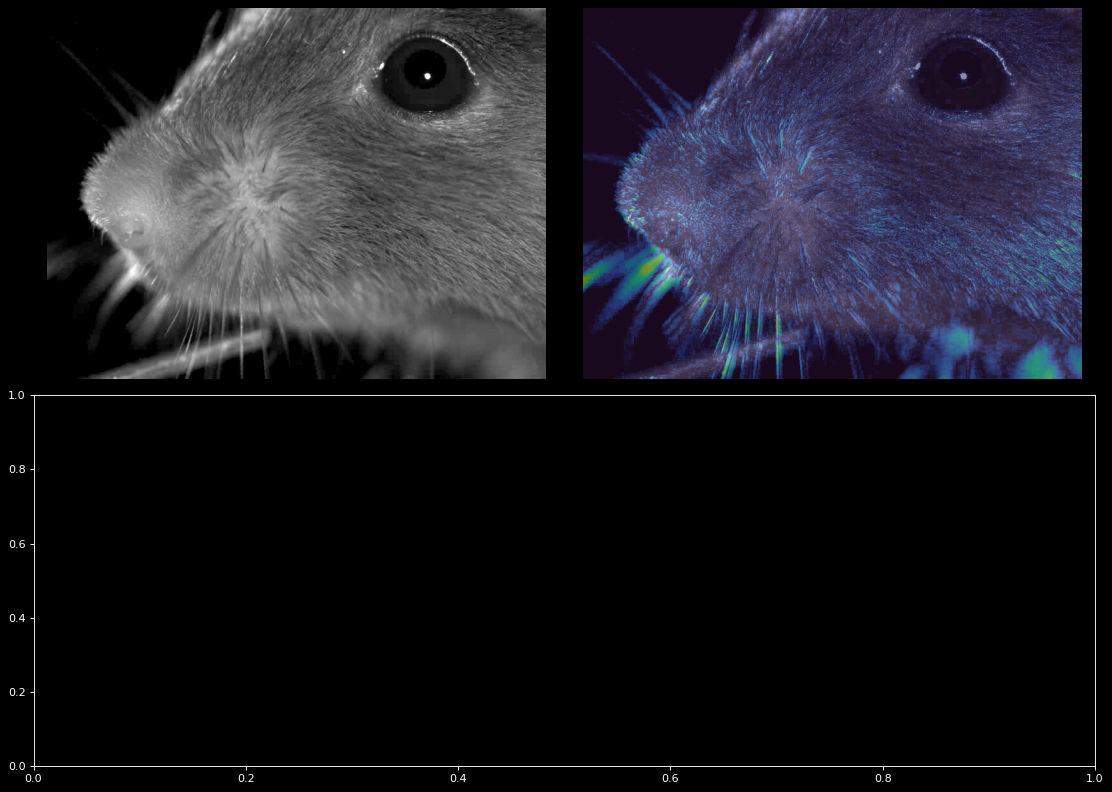

In [40]:

#def create_labeled_video_face(params, dlc_face, pupil, face, facemasks, face_anchor, write_mp4=False, startframe=10000):

facemp4 = cv2.VideoCapture(params['paths']['Data_FaceCam'])
if 'FaceCam_FPS' not in params['cameras']:
    params['cameras']['FaceCam_FPS'] = int(facemp4.get(5))
if 'FaceCam_Width' not in params['cameras']:
    params['cameras']['FaceCam_Width'] = int(facemp4.get(3))
if 'FaceCam_Height' not in params['cameras']:
    params['cameras']['FaceCam_Height'] = int(facemp4.get(4))
if params['cameras']['face_output'] > 1:
    vidlength = round(params['cameras']['face_output'])
else:
    vidlength = int(facemp4.get(7))
print("Labelling face video...")
if facemp4.get(7)>=startframe+vidlength:
    facemp4.set(1, startframe)
else:
    startframe = 1000
ret, current_frame = facemp4.read()
previous_frame = current_frame
index = startframe

plt.close("all")
# plt.ioff()  # hide figures
plt.ion()  # show figures
fig, axd = plt.subplot_mosaic([['upper left', 'upper right'],
                                ['bottom', 'bottom']], figsize=(14, 10), dpi=80)
if params['cameras']['use_dark_background']:
    plt.style.use('dark_background')
else:
    plt.style.use('default')

# if write_mp4:
#     fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
#     out = cv2.VideoWriter(params['paths']['Results_FaceVid'], fourcc, int(params['cameras']['FaceCam_FPS']), (1120, 800))
# elif not os.path.exists(os.path.join(params['paths']['Results_Cam_Dir'], 'face_output_vid_'+os.path.basename(params['paths']['Data_FaceCam'])[:-4])):
#     os.makedirs(os.path.join(params['paths']['Results_Cam_Dir'], 'face_output_vid_'+os.path.basename(params['paths']['Data_FaceCam'])[:-4]))

# # face = face[['PupilDiam', 'Saccades', 'EyeLidDist', 'EyeBlinks']]
# face = behaviour[['optobout', 'OFmag_Nose', 'OFmag_Whiskerpad', 'PointMotion_FrontPaw', 'velocity']]
# face[['OFmag_Nose', 'OFmag_Whiskerpad']] = face[['OFmag_Nose', 'OFmag_Whiskerpad']].rolling(5, center=True).mean()/2
# face['optobout'] = face['optobout'].astype(int)
# face['velocity'] = face['velocity']/8
# face['PointMotion_FrontPaw'] = (face['PointMotion_FrontPaw']/5).interpolate(method='linear').rolling(5, center=True).mean()
# facenames = list(face.columns)
# facedatapoints = face.values[:]
# minvalue = min(np.array(face.quantile(q=.05)))# - np.array(range(len(face.columns))))
# maxvalue = max(np.array(face.quantile(q=.95)))# - np.array(range(len(face.columns))))
# showseconds = 4 # 10
# showtimepoints = int(params['cameras']['FaceCam_FPS']) * showseconds
# midpoint = int(showtimepoints/2)
cmap = plt.get_cmap('Dark2')

with tqdm(total=vidlength) as pbar:
    while facemp4.isOpened():
        # shift X window of data
        # # axd['upper left'] = fig.add_subplot(2, 1, 2)
        # axd['bottom'].cla()
        # axd['bottom'].set_xlim(0, showtimepoints)
        # axd['bottom'].set_xticks(np.arange(0, showtimepoints, int(params['cameras']['FaceCam_FPS']/2)))
        # axd['bottom'].set_xticklabels([str(a) for a in [-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]], fontdict={'fontsize':12})
        # axd['bottom'].set_ylim(minvalue, maxvalue-1)
        # axd['bottom'].set_yticks(np.arange(-len(face.columns)+1, 1))
        # axd['bottom'].set_yticklabels(reversed(facenames), fontdict={'fontsize':12, 'fontweight':'bold'})
        # facedatapointsshifted = shift5(facedatapoints, midpoint-index)
        # for i in range(len(facedatapoints.transpose())):
        #     axd['bottom'].axhline(y=-i, linestyle='--', color=cmap(i), alpha=.5, linewidth=1.2)
        #     axd['bottom'].plot(facedatapointsshifted.transpose()[i] - i, color=cmap(i))
        #     # plt.legend(facenames, loc=2)
        # if params['cameras']['use_dark_background']:
        #     axd['bottom'].axvline(x=midpoint, color='white')
        # else:
        #     axd['bottom'].axvline(x=midpoint, color='black')
        # j = len(face.columns)-1
        # for i in plt.gca().get_yticklabels():
        #     i.set_color(cmap(j))
        #     j -= 1
        # axd['bottom'].set_xlabel('Time [sec]')

        # plot face frame
        # axd['upper right'] = fig.add_subplot(2, 2, 1)
        axd['upper left'].cla()
        gammaImg = gammaCorrection(current_frame, 1.5)
        # opto marker
        # if index>87_004:
        #     cv2.rectangle(gammaImg, pt1=(10, 80), pt2=(30, 100), color=(0, 0, 255), thickness=-1)
        axd['upper left'].imshow(gammaImg)
        axd['upper left'].axis('off')
        plt.tight_layout()
        # axd['upper left'].text(10, 30, str(params['paths']['Data_FaceCam'][-22:]), color='w', size=8)
        # axd['upper left'].text(10, 60, "%06d" % index, color='w')

        # # plot fix points
        # for key in face_anchor:
        #     axd['upper left'].scatter(face_anchor[key][0], face_anchor[key][1], s=200, color='w', alpha=.5)

        # # plot skeleton
        # axd['upper left'].plot([face_anchor.nosetip[0], face_anchor.forehead[0]], [face_anchor.nosetip[1], face_anchor.forehead[1]], color='w')
        # axd['upper left'].plot([face_anchor.nosetip[0], face_anchor.mouthtip[0]], [face_anchor.nosetip[1], face_anchor.mouthtip[1]], color='w')
        # axd['upper left'].plot([face_anchor.nosetip[0], face_anchor.tearduct[0]], [face_anchor.nosetip[1], face_anchor.tearduct[1]], color='w')
        # axd['upper left'].plot([face_anchor.mouthtip[0], face_anchor.tearduct[0]], [face_anchor.mouthtip[1], face_anchor.tearduct[1]], color='w')
        # axd['upper left'].plot([face_anchor.eyelid_bottom[0], face_anchor.chin[0]], [face_anchor.eyelid_bottom[1], face_anchor.chin[1]], color='w')

        # # plot dynamic DLC points whole face
        # for i in range(np.uint8(len(dlc_face.columns)/3)-6):
        #     axd['upper left'].scatter(dlc_face.values[index][i*3], dlc_face.values[index][i*3+1], alpha=0.7, s=100, color='w')
        # axd['upper left'].scatter(pupil['x_raw'][index], pupil['y_raw'][index], alpha=0.7, s=30, color='w')
        # axd['upper left'].set_xlim(0, params['cameras']['FaceCam_Width'])
        # axd['upper left'].set_ylim(params['cameras']['FaceCam_Height'], 0)

        # calculate optical flow using GPU
        previous_frame_gray = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
        current_frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        # gpu_frame = cv2.cuda_GpuMat()
        # gpu_frame.upload(current_frame_gray)
        # gpu_previous = cv2.cuda_GpuMat()
        # gpu_previous.upload(previous_frame_gray)
        # gpu_flow = cv2.cuda_FarnebackOpticalFlow.create(numLevels=5, pyrScale=.5, fastPyramids=True, winSize=25,
        #                                                 numIters=3, polyN=5, polySigma=1.2, flags=0)
        flow = cv2.absdiff(current_frame_gray, previous_frame_gray) * 2
        # flow = gpu_flow.calc(gpu_frame, gpu_previous, None)
        # flow_color = flow_vis.flow_to_color(flow.download(), convert_to_bgr=True)
        flow_color = cv2.cvtColor(cv2.applyColorMap(flow.astype('uint8'), me_cmap), cv2.COLOR_BGR2RGB)
        dst = cv2.addWeighted(current_frame, blend_gray_optflow, flow_color, 1-blend_gray_optflow, 0)

        # plot optical flow
        axd['upper right'].cla()
        axd['upper right'].imshow(dst)
        axd['upper right'].axis('off')
        plt.tight_layout()

        # plot face regions
        #for i in range(len(facemasks)):
        # axd['upper right'].contour(facemasks[0], colors=[cmap(1)], linestyles='--', linewidths=2)
        # axd['upper right'].contour(facemasks[2], colors=[cmap(2)], linestyles='--', linewidths=2)
        # axd['upper right'].text(10, 30, "Farneback Dense Optical Flow", color='k')

        # # plot eye detail
        # # axd['bottom'] = fig.add_subplot(2, 2, 2)
        # axd['upper right'].cla()
        # pupilmeanx = np.round(np.mean(pupil['x_smooth'])).astype(int)
        # pupilmeany = np.round(np.mean(pupil['y_smooth'])).astype(int)
        # axd['upper right'].imshow(current_frame_gray[pupilmeany-90:pupilmeany+90, pupilmeanx-120:pupilmeanx+120], cmap='gray')
        # axd['upper right'].axis('off')
        # plt.tight_layout()

        # # plot eye DLC points
        # for i in range(4, np.uint8(len(dlc_face.columns)/3)):
        #     axd['upper right'].scatter(dlc_face.values[index][i*3]-(pupilmeanx-120), dlc_face.values[index][i*3+1]-(pupilmeany-90), alpha=1, s=100, color='w')
        # axd['upper right'].plot([(dlc_face.values[index][12]-(pupilmeanx-120)), (dlc_face.values[index][15]-(pupilmeanx-120))], [(dlc_face.values[index][13]-(pupilmeany-90)), (dlc_face.values[index][16]-(pupilmeany-90))], color=cmap(1))
        # axd['upper right'].plot([(dlc_face.values[index][12]-(pupilmeanx-120)), (dlc_face.values[index][18]-(pupilmeanx-120))], [(dlc_face.values[index][13]-(pupilmeany-90)), (dlc_face.values[index][19]-(pupilmeany-90))], color=cmap(1))
        # axd['upper right'].scatter(pupil['x_raw'][index]-(pupilmeanx-120), pupil['y_raw'][index]-(pupilmeany-90), alpha=0.7, s=100, color='w')

        # # plot pupil
        # pupilplot = plt.Circle((np.round(pupil['x_interp'][index]).astype(int)-(pupilmeanx-120), np.round(pupil['y_interp'][index]).astype(int)-(pupilmeany-90)), np.round(pupil['diam_interp'][index]).astype(int), color=cmap(0), alpha=0.5, fill=False, linewidth=3)
        # axd['upper right'].add_artist(pupilplot)

        plt.savefig(os.path.join(params['paths']['Results_Cam_Dir'], 'face_output_vid_'+os.path.basename(params['paths']['Data_FaceCam'])[:-4], '') + "file%06d.png" % index)

        pbar.update(1)
        index += 1
        if index > startframe+vidlength:
            break
        previous_frame = current_frame.copy()
        ret, current_frame = facemp4.read()
        if current_frame is None:
            break
# if write_mp4:
#     out.release()
facemp4.release()
# plt.close('all')
plt.show()

In [29]:
facemasks

[nan, nan, nan, nan]